# Projet 4 : Anticiper les besoins en consommation de bâtiments

Dans ce projet n°4 de la formation Data Scientist d'OC, nous allons nous intéresser à la consommation en énergie des bâtiments non résidentiels de la ville de Seattle, afin d'entraîner un algorithme de machine learning supervisé pour prédire les besoins en énergie des potentiels futurs bâtiments en construction.
Afin de procéder à cela, nous allons tout d'abord explorer et nettoyer notre dataset afin d'obtenir les meilleures prédictions possibles.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import pyproj

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from matplotlib import rcParams

In [2]:
#On charge les données dans un dataframe
building_data = pd.read_csv("Energy_building_data.csv")

In [3]:
building_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

On voit qu'on étudie un set relativement petit, et plutôt bien renseigné, il y a en effet assez peu de valeurs manquantes. Avant de passer au nettoyage et de s'intéresser à ces valeurs, on va tout d'abord par commencer à faire un tri sur les variables. On souhaite conserver uniquement les variables qui vont nous servir pour entraîner notre algorithme. On va donc conserver Building et Property Types, une variable de localisation comme le Zipcode ou le Neighborood, YearBuilt, Nb of Buildings et Floors, la surface du bâtiment avec GFATotal et GFAParking, PropertyUseType. De plus, on va s'intéresser à ENERGYSTARScore dans notre analyse donc on le garde, SiteEnergyUse et SiteEUI, avec et sans la WN sont importants car c'est ce qu'on cherche à prédire dans notre étude, en revanche les variables Source ne nous intéressent pas car on veut juste chercher la consommation. On garde évidemment SteamUse, Electricity et NaturalGas car ce sont les composantes de notre consommation d'énergie, on va uniquement les garder en kBtu qui est l'unité qui est utilisé pour les variables précédentes. Enfin on va conserver DefaultData, ComplianceStatus et Outlier qui vont nous servir à trier nos données, et les deux variables GHGEEmissions qui sont notre autre sujet de prédiction.

## Nettoyage des données

In [4]:
#On garde les variables qu'on a choisies, plus quelques-unes qui vont nous servir pour trier.
building_data = building_data.iloc[:,[2,3,8,11,12,13,14,15,16,17,18,21,28,29,30,33,34,35,37,39,40,42,43,44,45]]

In [5]:
building_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BuildingType            3376 non-null   object 
 1   PrimaryPropertyType     3376 non-null   object 
 2   ZipCode                 3360 non-null   float64
 3   Neighborhood            3376 non-null   object 
 4   Latitude                3376 non-null   float64
 5   Longitude               3376 non-null   float64
 6   YearBuilt               3376 non-null   int64  
 7   NumberofBuildings       3368 non-null   float64
 8   NumberofFloors          3376 non-null   int64  
 9   PropertyGFATotal        3376 non-null   int64  
 10  PropertyGFAParking      3376 non-null   int64  
 11  LargestPropertyUseType  3356 non-null   object 
 12  ENERGYSTARScore         2533 non-null   float64
 13  SiteEUI(kBtu/sf)        3369 non-null   float64
 14  SiteEUIWN(kBtu/sf)      3370 non-null   

On va maintenant commencer à traiter nos données. Pour commencer, on rappelle que dans notre énoncé de projet on s'intéresse uniquement aux bâtiments non résidentiels, or dans notre dataset on retrouve de nombreux bâtiments résidentiels, on va donc s'en séparer tout de suite.

In [6]:
building_data['BuildingType'].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [7]:
#On supprime les bâtiments résidentiels
building_data.drop(building_data.loc[((building_data['BuildingType']=='Multifamily LR (1-4)') | 
                                      (building_data['BuildingType']=='Multifamily MR (5-9)') | 
                                      (building_data['BuildingType']=='Multifamily HR (10+)'))].index, inplace=True)

On va maintenant faire un nouveau tri, en regardant cette fois le ComplianceStatus, en effet on va uniquement conserver les lignes où cette variable est "Compliant" afin d'avoir des données cohérentes et éviter les erreurs.

In [8]:
building_data.drop(building_data.loc[~(building_data['ComplianceStatus']=='Compliant')].index, inplace=True)
building_data.reset_index(drop=True,inplace=True)

In [9]:
building_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548 entries, 0 to 1547
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BuildingType            1548 non-null   object 
 1   PrimaryPropertyType     1548 non-null   object 
 2   ZipCode                 1535 non-null   float64
 3   Neighborhood            1548 non-null   object 
 4   Latitude                1548 non-null   float64
 5   Longitude               1548 non-null   float64
 6   YearBuilt               1548 non-null   int64  
 7   NumberofBuildings       1548 non-null   float64
 8   NumberofFloors          1548 non-null   int64  
 9   PropertyGFATotal        1548 non-null   int64  
 10  PropertyGFAParking      1548 non-null   int64  
 11  LargestPropertyUseType  1544 non-null   object 
 12  ENERGYSTARScore         997 non-null    float64
 13  SiteEUI(kBtu/sf)        1548 non-null   float64
 14  SiteEUIWN(kBtu/sf)      1547 non-null   

 On remarque qu'avec les précédents tris, on a pu se débarrasser des valeurs indiquées Outliers, donc on a même plus besoin de la trier on peut simplement la supprimer directement. De même, on a désormais plus besoin de ComplianceStatus ou de DefaultData. 
 
Les seules valeurs manquantes qu'il nous reste sont donc dans ENERGYSTARScore mais on ne va pas y toucher, quelques ZipCode qui seront faciles à trouver si on décide de les garder, et enfin 2 valeurs manquantes sur la même ligne concernant les variables d'énergie WN, qu'on pourra également imputer au besoin car on a toutes les autres valeurs.

In [10]:
building_data.drop(['Outlier','ComplianceStatus', 'DefaultData'], axis=1, inplace=True)

Faisons maintenant un choix sur notre variable de localisation, on en a gardé 2, Neigbhourhood et ZipCode, comparons les deux afin de choisir la meilleure pour notre algorithme.

In [11]:
print(building_data['ZipCode'].sort_values().unique())
print(building_data['ZipCode'].value_counts())

[98006. 98011. 98013. 98020. 98033. 98053. 98070. 98101. 98102. 98103.
 98104. 98105. 98106. 98107. 98108. 98109. 98111. 98112. 98113. 98114.
 98115. 98116. 98117. 98118. 98119. 98121. 98122. 98124. 98125. 98126.
 98133. 98134. 98136. 98144. 98145. 98146. 98154. 98155. 98164. 98165.
 98168. 98177. 98178. 98181. 98185. 98191. 98195. 98199.    nan]
98134.0    180
98104.0    153
98101.0    144
98109.0    138
98108.0    111
98122.0     86
98121.0     83
98105.0     80
98103.0     63
98119.0     60
98133.0     48
98107.0     47
98125.0     45
98144.0     42
98115.0     41
98118.0     32
98102.0     24
98106.0     22
98199.0     21
98116.0     18
98126.0     18
98112.0     17
98117.0     14
98195.0      9
98136.0      5
98155.0      4
98124.0      2
98013.0      2
98177.0      2
98154.0      2
98178.0      2
98146.0      2
98111.0      2
98168.0      2
98114.0      1
98011.0      1
98165.0      1
98020.0      1
98113.0      1
98181.0      1
98053.0      1
98006.0      1
98185.0      1
98164.

In [12]:
building_data['Neighborhood'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'NORTHWEST', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'DELRIDGE', 'NORTH', 'North', 'Delridge',
       'Ballard', 'Northwest', 'Central', 'DELRIDGE NEIGHBORHOODS'],
      dtype=object)

On peut voir qu'on a beaucoup plus de Zipcodes que de Neighborhood, ce qui est bien pour une meilleure précision, mais qui peut également poser problème car de nombreux Zicodes ne représentent qu'un ou deux bâtiments et cela peut nuire à notre prédiction. De plus, cela représentera un nombre conséquent de classes lors de notre encodage. On va donc préférer garder la variable 'Neighborhood' pour notre étude qui sera plus pertinente. On peut néanmoins voir quelques doublons dus à des problèmes de format des noms qu'on va devoir corriger.

In [13]:
dict_neighborood = {'North':'NORTH','Delridge':'DELRIDGE','Ballard':'BALLARD','Northwest':'NORTHWEST','Central':'CENTRAL','DELRIDGE NEIGHBORHOODS':'DELRIDGE'}
building_data['Neighborhood'].replace(dict_neighborood, inplace=True)
building_data.drop(['ZipCode'], axis=1, inplace=True)

Regardons également de plus près les variables qui décrivent le type de building, ici encore on a gardé PrimaryPropertyType et LargestPropertyUseType donc il va falloir choisir une des deux.

In [14]:
building_data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'Warehouse', 'K-12 School', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Low-Rise Multifamily'],
      dtype=object)

In [15]:
#On constate 'Low Rise Multifamily' dans la liste
building_data.loc[building_data['PrimaryPropertyType']=='Low-Rise Multifamily']

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
578,NonResidential,Low-Rise Multifamily,LAKE UNION,47.64859,-122.33311,2000,1.0,3,93079,36093,...,32.0,21.900000,23.000000,1997181.5,2090011.625,0.0,1744199.0,252982.0,25.60,0.28
843,Campus,Low-Rise Multifamily,DOWNTOWN,47.60918,-122.34079,1942,1.0,4,45500,0,...,NaN,85.199997,85.199997,3778355.0,3778355.000,0.0,3778355.0,0.0,26.34,0.58


En regardant en détail les PrimaryPropertyType, on voit que 2 bâtiments étaient recensés comme NonResidential et Campus mais sont en fait des Low-Rise Multifamily, c'est-à-dire des bâtiments résidentiels, on va donc les retirer.

In [16]:
building_data.drop(building_data.loc[building_data['PrimaryPropertyType']=='Low-Rise Multifamily'].index, inplace=True)

In [17]:
print(building_data['PrimaryPropertyType'].value_counts())
print('------------------------------------------------')
print(building_data['LargestPropertyUseType'].value_counts())

Small- and Mid-Sized Office    286
Other                          245
Warehouse                      185
Large Office                   169
Mixed Use Property             113
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             53
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      24
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64
------------------------------------------------
Office                                                  485
Non-Refrigerated Warehouse                              197
Other                                                    95
Retail Store                   

On a 2 variables qui précisent l'utilisation du bâtiment, une est beaucoup plus précise que l'autre et présente 56 observations différentes, contre 20. Une plus grande précision permettrait un meilleur apprentissage pour une précision de bâtiment, cependant il faut faire attention à ne pas overfit nos données, et ça pourrait facilement être le cas avec autant de types différents. De plus de nombreuses catégories de bâtiments ne comportent qu'un ou deux bâtiments dans le LargestPropertyUseType.
On va donc garder la variable PrimaryPropertyType, faisons cependant attention lors de la prédiction, car la catégorie Other comprend de nombreux bâtiments qui doivent sûrement être très variés donc ça peut poser problème sur notre apprentissage.

In [18]:
building_data.drop('LargestPropertyUseType', axis=1, inplace=True)

In [19]:
building_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1546 entries, 0 to 1547
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   BuildingType           1546 non-null   object 
 1   PrimaryPropertyType    1546 non-null   object 
 2   Neighborhood           1546 non-null   object 
 3   Latitude               1546 non-null   float64
 4   Longitude              1546 non-null   float64
 5   YearBuilt              1546 non-null   int64  
 6   NumberofBuildings      1546 non-null   float64
 7   NumberofFloors         1546 non-null   int64  
 8   PropertyGFATotal       1546 non-null   int64  
 9   PropertyGFAParking     1546 non-null   int64  
 10  ENERGYSTARScore        996 non-null    float64
 11  SiteEUI(kBtu/sf)       1546 non-null   float64
 12  SiteEUIWN(kBtu/sf)     1545 non-null   float64
 13  SiteEnergyUse(kBtu)    1546 non-null   float64
 14  SiteEnergyUseWN(kBtu)  1545 non-null   float64
 15  Stea

## Valeurs Aberrantes

On va maintenant s'intéresser plus directement aux valeurs dans notre dataset afin de détecter des valeurs aberrantes dans les variables numériques.

<AxesSubplot: xlabel='NumberofBuildings', ylabel='count'>

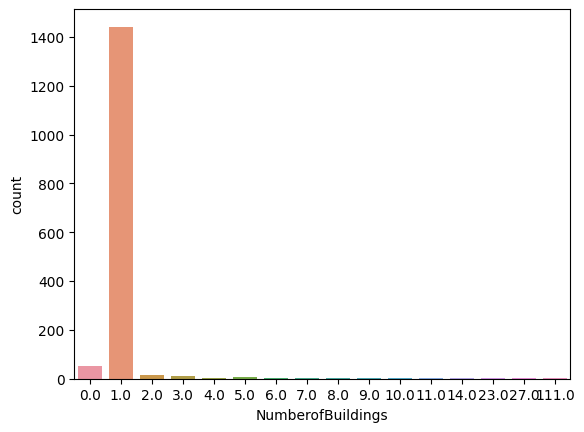

In [20]:
#Regardons d'abord sur le nombre de bâtiments
sns.countplot(building_data, x='NumberofBuildings')

In [21]:
#On a quelques valeurs très élevées, regardons en détail
building_data.loc[building_data['NumberofBuildings']>9]

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
89,Campus,University,DELRIDGE,47.54700,-122.35307,1970,27.0,2,441071,0,NaN,79.300003,85.199997,38301744.0,41151732.0,0.0,25314575.0,12987166.0,866.23,1.96
106,Campus,University,NORTHWEST,47.69936,-122.33401,1970,11.0,2,694072,111625,NaN,53.799999,56.099998,35891484.0,37410800.0,0.0,33450832.0,2440648.0,362.82,0.52
127,Campus,Large Office,GREATER DUWAMISH,47.52429,-122.31234,1980,14.0,2,334368,31874,NaN,159.899994,161.899994,53466684.0,54136068.0,0.0,45321378.0,8145300.0,748.55,2.24
1017,Campus,Other,MAGNOLIA / QUEEN ANNE,47.65561,-122.38063,1955,23.0,1,260241,0,NaN,130.699997,138.500000,34012980.0,36034584.0,0.0,26894616.0,7118362.0,565.55,2.17
1074,Campus,Other,GREATER DUWAMISH,47.59042,-122.32498,1991,10.0,0,230971,0,NaN,91.000000,96.199997,21022288.0,22230844.0,0.0,15419770.0,5602515.0,405.05,1.75
1223,Campus,University,MAGNOLIA / QUEEN ANNE,47.65019,-122.36173,1945,14.0,2,537000,0,NaN,169.699997,181.300003,90609640.0,96775464.0,0.0,22619097.0,67990538.0,3768.66,7.02
1510,Campus,University,NORTHEAST,47.65644,-122.31041,1900,111.0,0,9320156,0,NaN,93.800003,0.000000,873923712.0,0.0,84985240.0,657074389.0,0.0,11140.56,1.20


Toutes ces lignes ont des valeurs assez élevées, cependant elles correspondent à des campus d'Université, donc un nombre de buildings élevé est normal. Même pour les 111 buildings, le bâtiment en question est l'Université de Washington, une université historique très conséquente, donc cette valeur est surprenante mais correcte.

<AxesSubplot: xlabel='NumberofFloors', ylabel='count'>

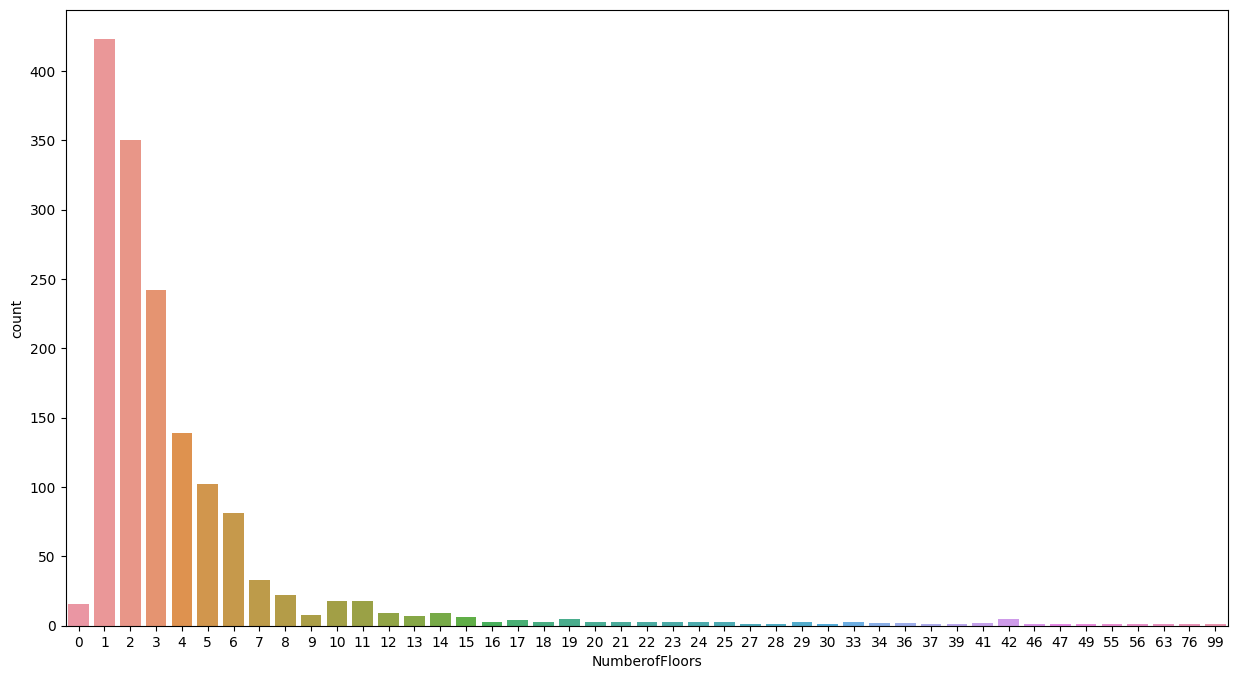

In [22]:
#Regardons maintenant le nombre d'étages
rcParams['figure.figsize'] = 15,8
sns.countplot(building_data, x='NumberofFloors')

In [23]:
building_data.loc[building_data['NumberofFloors']>50]

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
183,Nonresidential COS,Large Office,DOWNTOWN,47.60501,-122.32988,1990,1.0,63,1354987,159600,89.0,50.400002,50.400002,6.157618e+07,6.157618e+07,0.000,61576180.0,0.0,429.27,0.32
221,NonResidential,Large Office,DOWNTOWN,47.60723,-122.33611,1988,1.0,55,1400000,285000,92.0,46.700001,48.500000,5.307916e+07,5.514030e+07,2179487.750,49472833.0,1426840.0,588.90,0.42
241,NonResidential,Large Office,DOWNTOWN,47.61043,-122.33206,1989,1.0,56,1605578,389860,97.0,36.799999,37.900002,4.951770e+07,5.098450e+07,915654.875,46081813.0,2520230.0,525.78,0.33
499,NonResidential,Large Office,DOWNTOWN,47.60454,-122.33072,1985,1.0,76,1952220,319400,86.0,55.299999,55.099998,9.293764e+07,9.253726e+07,0.000,87851862.0,5085763.0,882.56,0.45
867,NonResidential,Worship Facility,GREATER DUWAMISH,47.55072,-122.30265,1977,1.0,99,21948,0,80.0,14.900000,14.900000,3.260012e+05,3.260012e+05,0.000,326001.0,0.0,2.27,0.10


Le plus grand immeuble de Seattle comprend bien 76 étages, donc pas de problème pour cela, cependant on a bien une valeur aberrantes avec 99 étages, surtout quand on compare avec la surface totale on voit bien qu'on a un problème. On va donc supprimer ce bâtiment.

In [24]:
building_data.drop(building_data.loc[building_data['NumberofFloors']==99].index, inplace=True)

In [25]:
#On peut également regarder la surface totale
building_data.sort_values('PropertyGFATotal', ascending=False)

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
1510,Campus,University,NORTHEAST,47.656440,-122.310410,1900,111.0,0,9320156,0,NaN,93.800003,0.000000,8.739237e+08,0.000000e+00,8.498524e+07,6.570744e+08,0.000000e+00,11140.56,1.20
906,Campus,University,EAST,47.610650,-122.317110,1939,1.0,2,2200000,0,NaN,66.699997,71.599998,1.146485e+08,1.232056e+08,0.000000e+00,6.167282e+07,5.297569e+07,3243.48,1.47
499,NonResidential,Large Office,DOWNTOWN,47.604540,-122.330720,1985,1.0,76,1952220,319400,86.0,55.299999,55.099998,9.293764e+07,9.253726e+07,0.000000e+00,8.785186e+07,5.085763e+06,882.56,0.45
556,NonResidential,Hospital,EAST,47.608951,-122.322402,1994,7.0,14,1765970,0,54.0,177.899994,180.500000,2.916144e+08,2.959299e+08,1.349435e+08,1.393548e+08,1.731612e+07,12307.16,6.97
241,NonResidential,Large Office,DOWNTOWN,47.610430,-122.332060,1989,1.0,56,1605578,389860,97.0,36.799999,37.900002,4.951770e+07,5.098450e+07,9.156549e+05,4.608181e+07,2.520230e+06,525.78,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.636440,-122.357840,1974,1.0,1,13157,0,NaN,438.200012,460.100006,5.765898e+06,6.053764e+06,0.000000e+00,1.792159e+06,3.973739e+06,223.54,16.99
1540,Nonresidential COS,Other,BALLARD,47.677340,-122.376240,1972,1.0,1,12769,0,NaN,400.799988,420.600006,5.117308e+06,5.370264e+06,0.000000e+00,1.205173e+06,3.912135e+06,216.18,16.93
1537,Nonresidential COS,Other,BALLARD,47.693300,-122.377170,2010,1.0,1,11968,0,NaN,65.500000,71.800003,7.834230e+05,8.587730e+05,0.000000e+00,4.032431e+05,3.801800e+05,23.00,1.92
1536,Nonresidential COS,Other,CENTRAL,47.599050,-122.297870,2013,1.0,1,11685,0,NaN,72.800003,82.900002,8.510538e+05,9.691420e+05,0.000000e+00,3.472887e+05,5.037650e+05,29.18,2.50


A priori pas de valeurs aberrantes sur la surface totale, cependant on remarque des valeurs qui semblent peu cohérentes. En effet, la première ligne a 111 bâtiments, mais pas d'indications sur les étages et 9km² de surface. Et en regardant les 2 suivantes, on a un Campus avec 1 bâtiment, 2 étages qui fait 2km² ce qui est énorme pour un bâtiment unique, là où sur le 3e on voit qu'on a 2km² également mais pour 76 étages.
On va tout de même les conserver pour l'instant mais à surveiller.


On va maintenant regarder les données d'énergie pour vérifier qu'on n'a pas de décalage sur nos valeurs entre les différentes variables.

In [26]:
#On regarde si des bâtiments ont des valeurs nulles sur toutes les sources d'énergie.
building_data.loc[(building_data['SteamUse(kBtu)']==0) & (building_data['Electricity(kBtu)']==0) & (building_data['NaturalGas(kBtu)']==0)]

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
454,NonResidential,Supermarket / Grocery Store,MAGNOLIA / QUEEN ANNE,47.63718,-122.37734,2008,1.0,1,57176,0,31.0,208.800003,214.100006,12525174.0,12843856.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#Pas de valeurs dans les sources d'énergie, ni dans les émissions, on va retirer la ligne.

index = building_data.loc[(building_data['SteamUse(kBtu)']==0) & (building_data['Electricity(kBtu)']==0) & (building_data['NaturalGas(kBtu)']==0)].index
building_data.drop(index,inplace=True)
building_data.reset_index(drop=True,inplace=True)

In [28]:
#On regarde si on a des valeurs négatives
building_data.loc[(building_data['SteamUse(kBtu)']<0) | (building_data['Electricity(kBtu)']<0) | (building_data['NaturalGas(kBtu)']<0)]

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
1484,NonResidential,Small- and Mid-Sized Office,CENTRAL,47.61432,-122.31257,2013,1.0,6,52000,0,100.0,7.1,5.0,342726.0938,240132.0938,0.0,-115417.0,0.0,-0.8,-0.02


In [29]:
index = building_data.loc[(building_data['SteamUse(kBtu)']<0) | (building_data['Electricity(kBtu)']<0) | (building_data['NaturalGas(kBtu)']<0)].index
building_data.drop(index,inplace=True)
building_data.reset_index(drop=True,inplace=True)

In [30]:
#Regardons maintenant les valeurs avec quelques indicateurs statistiques.
building_data.iloc[:,10:].describe()

,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,993.000000,1543.000000,1542.000000,1.543000e+03,1.542000e+03,1.543000e+03,1.543000e+03,1.543000e+03,1543.000000,1543.000000
mean,63.647533,75.108425,77.555318,8.876475e+06,8.456852e+06,5.529691e+05,6.157024e+06,2.044738e+06,194.201672,1.672152
std,28.819492,75.209515,76.227364,3.135399e+07,2.281062e+07,5.727680e+06,2.154351e+07,9.725735e+06,780.297322,2.409967
min,1.000000,1.400000,0.000000,5.713320e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.400000,0.010000
25%,44.000000,34.950001,37.099998,1.253035e+06,1.322536e+06,0.000000e+00,7.343460e+05,0.000000e+00,20.760000,0.360000
50%,71.000000,53.799999,56.299999,2.735166e+06,2.825977e+06,0.000000e+00,1.749609e+06,4.911050e+05,50.050000,0.890000
75%,88.000000,85.149998,87.900002,7.298149e+06,7.476740e+06,0.000000e+00,5.267771e+06,1.531622e+06,147.620000,1.970000
max,100.000000,834.400024,834.400024,8.739237e+08,4.716139e+08,1.349435e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000


Les données sont cohérentes pour EUI et EUIWN, et les valeurs anormalement hautes semblent cohérentes également, juste très éloignée des autres. Regardons maintenant si les valeurs pour SiteEnergyUse correspondent bien aux sommes des variables 'SteamUse', 'Electricity' et 'NaturalGas'.

In [31]:
#On regarde maintenant s'il y a des différences entre les valeurs indiquées dans SiteEergyUse et dans les valeurs dans les variables sources.
abs((building_data['SiteEnergyUse(kBtu)'] - (building_data['SteamUse(kBtu)']+building_data['Electricity(kBtu)']+building_data['NaturalGas(kBtu)']))).describe()

count    1.543000e+03
mean     1.245138e+05
std      3.441593e+06
min      0.000000e+00
25%      1.875000e-01
50%      4.063000e-01
75%      1.000000e+00
max      1.318641e+08
dtype: float64

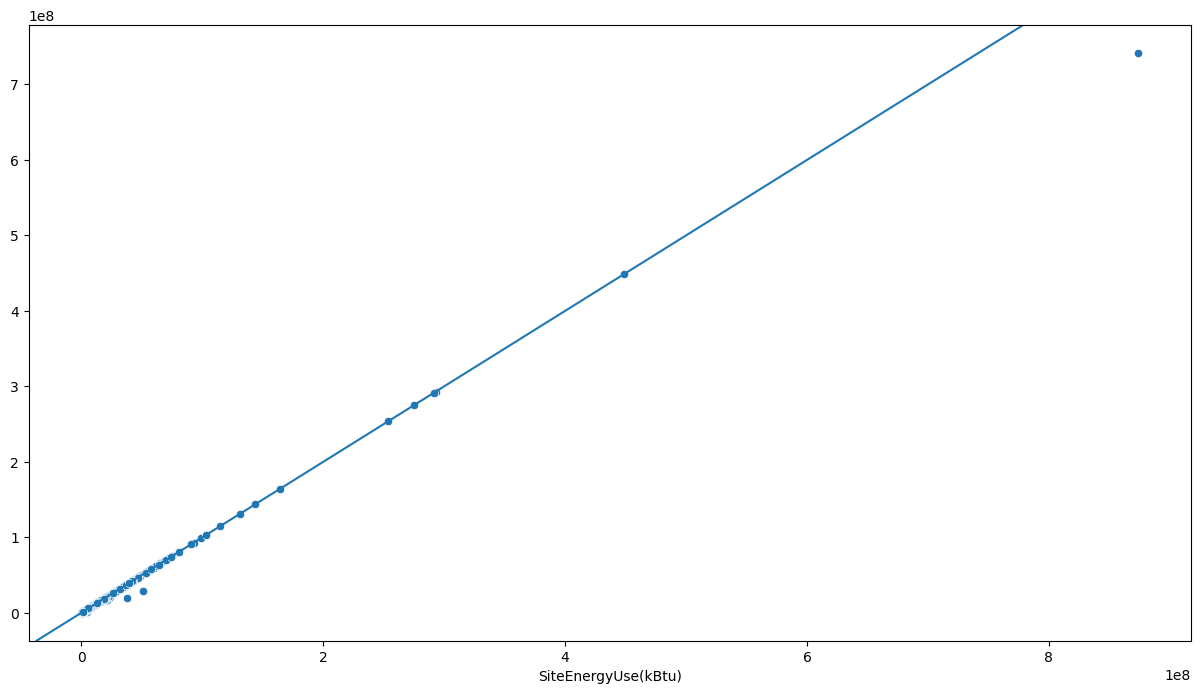

In [32]:
ax = sns.scatterplot(x=building_data['SiteEnergyUse(kBtu)'], y=building_data['SteamUse(kBtu)']+building_data['Electricity(kBtu)']+building_data['NaturalGas(kBtu)'])
ax.axline((0, 0), slope=1)

On voit qu'on a quelques outliers assez importants, sachant qu'au moins 75% des valeurs correspondent (à 1 près), comme on le voit dans le describe. Sur le graphe on voit que quasiment tous les bâtiments suivent la courbe x=y, mais notre échelle est d'1e8, donc on ne voit pas bien les écarts plus faibles (jusqu'à 1e6).

In [33]:
#On crée une nouvelle colonne pour afficher la différence entre les 2 valeurs
building_data['DiffEU'] = building_data['SiteEnergyUse(kBtu)'] - (building_data['SteamUse(kBtu)']+building_data['Electricity(kBtu)']+building_data['NaturalGas(kBtu)'])

In [34]:
#On regarde maintenant le pourcentage d'erreur que cette valeur représente
building_data['DiffEU%'] = (building_data['DiffEU']/building_data['SiteEnergyUse(kBtu)'])*100

In [35]:
building_data.loc[abs(building_data['DiffEU%'])>10]

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DiffEU,DiffEU%
62,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.62208,-122.35398,1962,1.0,1,389000,0,...,64.500000,2.365898e+07,2.373692e+07,6093150.0,14419146.0,688680.0,607.41,1.56,2.458002e+06,10.389299
64,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.62208,-122.35398,1938,1.0,5,396085,0,...,76.300003,2.095503e+07,2.125784e+07,9763690.0,7252325.0,0.0,804.20,2.03,3.939011e+06,18.797452
68,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.62395,-122.35143,1928,1.0,2,262048,0,...,70.300003,2.072325e+07,2.082352e+07,5137220.0,13512686.0,0.0,490.73,1.87,2.073342e+06,10.004908
350,NonResidential,Large Office,LAKE UNION,47.62029,-122.33078,2005,1.0,6,336700,124800,...,42.200001,9.058916e+06,9.200102e+06,0.0,7877393.0,0.0,54.92,0.16,1.181523e+06,13.042653
502,NonResidential,Large Office,DOWNTOWN,47.61051,-122.34439,1979,1.0,7,131143,87160,...,NaN,5.177270e+06,NaN,0.0,4871126.0,1416041.0,109.16,0.83,-1.109896e+06,-21.437870
539,NonResidential,Small- and Mid-Sized Office,DELRIDGE,47.54103,-122.33766,1929,1.0,3,85126,0,...,467.000000,3.795171e+07,3.807493e+07,0.0,18610055.0,685132.0,166.13,1.95,1.865652e+07,49.158581
829,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.62082,-122.35251,1992,1.0,2,40600,0,...,56.000000,2.485521e+06,2.470816e+06,137900.0,1509514.0,374537.0,41.06,1.01,4.635700e+05,18.650818
1094,NonResidential,Small- and Mid-Sized Office,GREATER DUWAMISH,47.57075,-122.32724,1962,1.0,1,28800,0,...,67.500000,2.107744e+06,2.438706e+06,0.0,786547.0,1028822.0,60.12,2.09,2.923748e+05,13.871456
1253,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,47.60071,-122.33377,1909,0.0,3,47215,0,...,46.400002,2.092696e+06,2.136896e+06,0.0,1597575.0,991813.0,63.81,1.35,-4.966920e+05,-23.734551
1346,NonResidential,Retail Store,DOWNTOWN,47.59935,-122.32468,1917,1.0,2,24550,0,...,42.000000,9.772303e+05,1.031448e+06,0.0,90201.0,114794.0,6.73,0.27,7.722353e+05,79.022857


On ne va pas retirer trop de lignes pour une première prédiction, on retire donc seulement les valeurs trop fortement différentes, on supprime les lignes avec plus de 20% d'écart.

In [36]:
index = building_data.loc[abs(building_data['DiffEU%'])>20].index
building_data.drop(index,inplace=True)
building_data.reset_index(drop=True, inplace=True)

In [37]:
#Ces colonnes ne nous servent plus, on les retire
building_data.drop(['DiffEU','DiffEU%'], axis=1, inplace=True)

Il reste dans notre dataset de nombreuses variables qui traitent de la consommation énergétique, et on va également devoir sélectionner certaines pour notre étude. Les variables qui indiquent l'intensité (Energie/surface) sont intéressantes mais ce n'est pas vraiment ce qu'on recherche directement. De plus, les valeurs "WN" indiquent une consommation plus moyenne sur une certaine période de temps sans prendre en compte les aléas climatiques, et donne ainsi une meilleure estimation pour la construction d'un nouveau bâtiment. On va donc uniquement conserver SiteEnergyUseWN pour l'énergie.

In [38]:
building_data.drop(['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)','SiteEnergyUse(kBtu)','GHGEmissionsIntensity'], axis=1, inplace=True)

Regardons s'il n'y a pas de problèmes sur cette variable en particulier

In [39]:
building_data.loc[building_data['SiteEnergyUseWN(kBtu)']==0]

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
171,NonResidential,Large Office,DOWNTOWN,47.60370,-122.33447,1958,1.0,17,378525,84600,69.0,0.0,10921066.00,13985064.0,0.0,940.47
197,NonResidential,Large Office,DOWNTOWN,47.61695,-122.32965,1988,1.0,20,497513,118744,65.0,0.0,0.00,26602310.0,220905.0,197.19
233,NonResidential,Large Office,DOWNTOWN,47.60923,-122.33625,1929,1.0,15,151039,0,84.0,0.0,2850077.75,2596546.0,0.0,238.09
298,NonResidential,Small- and Mid-Sized Office,MAGNOLIA / QUEEN ANNE,47.62014,-122.35768,1971,1.0,5,88000,21600,75.0,0.0,0.00,3484915.0,0.0,24.29
647,NonResidential,Worship Facility,NORTHWEST,47.67572,-122.32850,1910,1.0,2,23931,0,88.0,0.0,0.00,167075.0,329402.0,18.66
665,NonResidential,Worship Facility,NORTHEAST,47.68752,-122.29852,2000,1.0,2,31386,0,52.0,0.0,0.00,710478.0,417701.0,27.14
1500,Campus,University,NORTHEAST,47.65644,-122.31041,1900,111.0,0,9320156,0,NaN,0.0,84985240.00,657074389.0,0.0,11140.56


On remarque déjà qu'on a quelques lignes avec des valeurs nulles, dont une sur un de nos plus gros bâtiments, ce qui risque de fausser toutes nos prédictions, on va donc retirer ces quelques lignes.

In [40]:
building_data.drop(building_data.loc[building_data['SiteEnergyUseWN(kBtu)']==0].index, inplace=True)
building_data.reset_index(inplace=True,drop=True)

In [41]:
building_data.loc[building_data['SiteEnergyUseWN(kBtu)']>1e8]

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
30,Campus,Mixed Use Property,GREATER DUWAMISH,47.534930,-122.317880,1992,1.0,3,494835,0,8.0,471613856.0,0.0,150476283.0,297909000.0,16870.98
103,NonResidential,Hospital,NORTHEAST,47.662310,-122.281460,1953,6.0,10,879000,0,10.0,257764208.0,0.0,115641210.0,138191238.0,8145.52
131,NonResidential,Hospital,CENTRAL,47.607050,-122.309660,1990,6.0,5,597519,0,34.0,147299056.0,0.0,58754927.0,84668094.0,4906.33
133,NonResidential,Hospital,EAST,47.603990,-122.323770,2000,9.0,8,1158691,0,29.0,296671744.0,122575032.0,168683602.0,1832129.0,10734.57
285,Campus,Other,LAKE UNION,47.628550,-122.330350,1997,1.0,5,535947,0,NaN,137106112.0,0.0,64627449.0,66746425.0,3995.45
493,NonResidential,Other,DOWNTOWN,47.614380,-122.338710,1981,1.0,33,429405,0,98.0,274725984.0,0.0,274532495.0,149672.0,1921.82
549,NonResidential,Hospital,EAST,47.608951,-122.322402,1994,7.0,14,1765970,0,54.0,295929888.0,134943456.0,139354828.0,17316120.0,12307.16
894,Campus,University,EAST,47.610650,-122.317110,1939,1.0,2,2200000,0,NaN,123205560.0,0.0,61672821.0,52975694.0,3243.48
964,NonResidential,Hospital,NORTHWEST,47.714250,-122.336890,1966,8.0,1,415632,0,85.0,100328264.0,0.0,42864158.0,56096612.0,3278.11
967,NonResidential,Medical Office,EAST,47.620140,-122.312280,1964,1.0,3,591981,0,60.0,103985264.0,0.0,48002292.0,54671394.0,3238.24


<AxesSubplot: xlabel='SiteEnergyUseWN(kBtu)', ylabel='Count'>

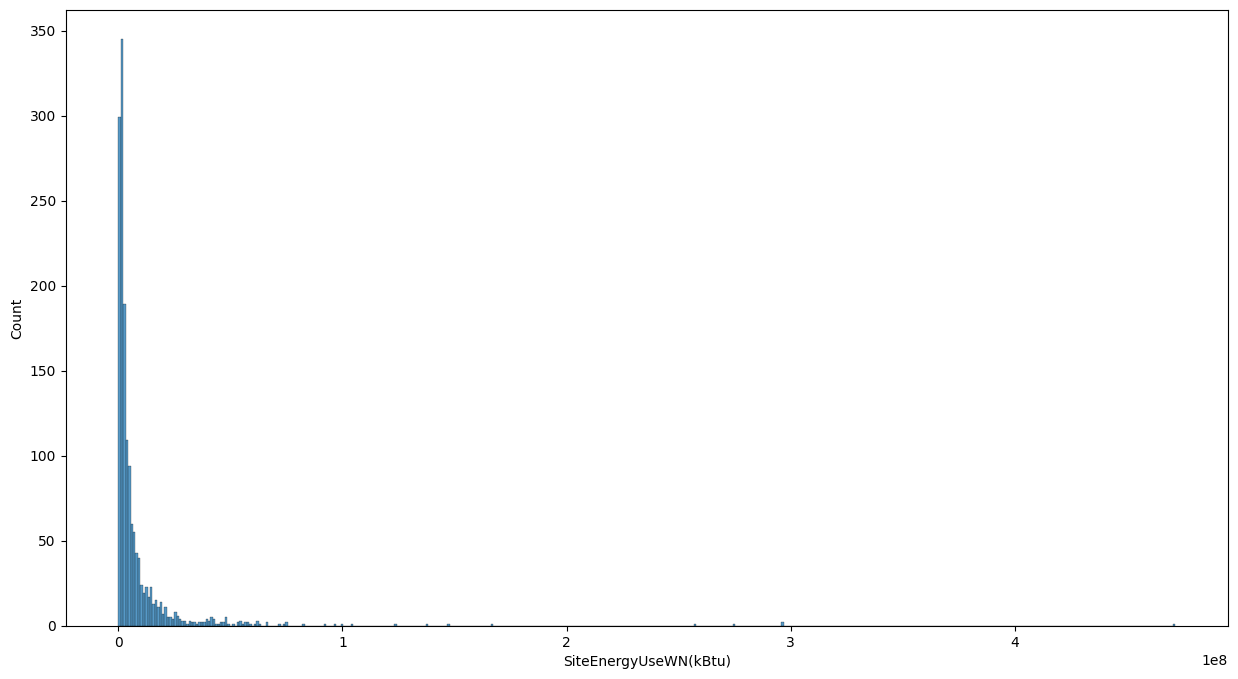

In [42]:
sns.histplot(building_data['SiteEnergyUseWN(kBtu)'])

Comme on peut le voir sur ce graph, on a quelques outliers très important en termes d'énergie. Les valeurs ne sont pas aberrantes, elles sont néanmoins très écartées de la totalité du dataset, et correspondent à des bâtiments uniques tels que des hôpitaux ou des universités. Afin d'obtenir les meilleurs résultats possibles sur nos prédictions, nous allons retirer ces valeurs.

In [43]:
index_drop = building_data.loc[building_data['SiteEnergyUseWN(kBtu)']>1e8].index
building_data.drop(index_drop,inplace=True)
building_data.reset_index(inplace=True,drop=True)

In [44]:
building_data.loc[building_data['SiteEnergyUseWN(kBtu)']>1e8]

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions


<AxesSubplot: xlabel='TotalGHGEmissions', ylabel='Count'>

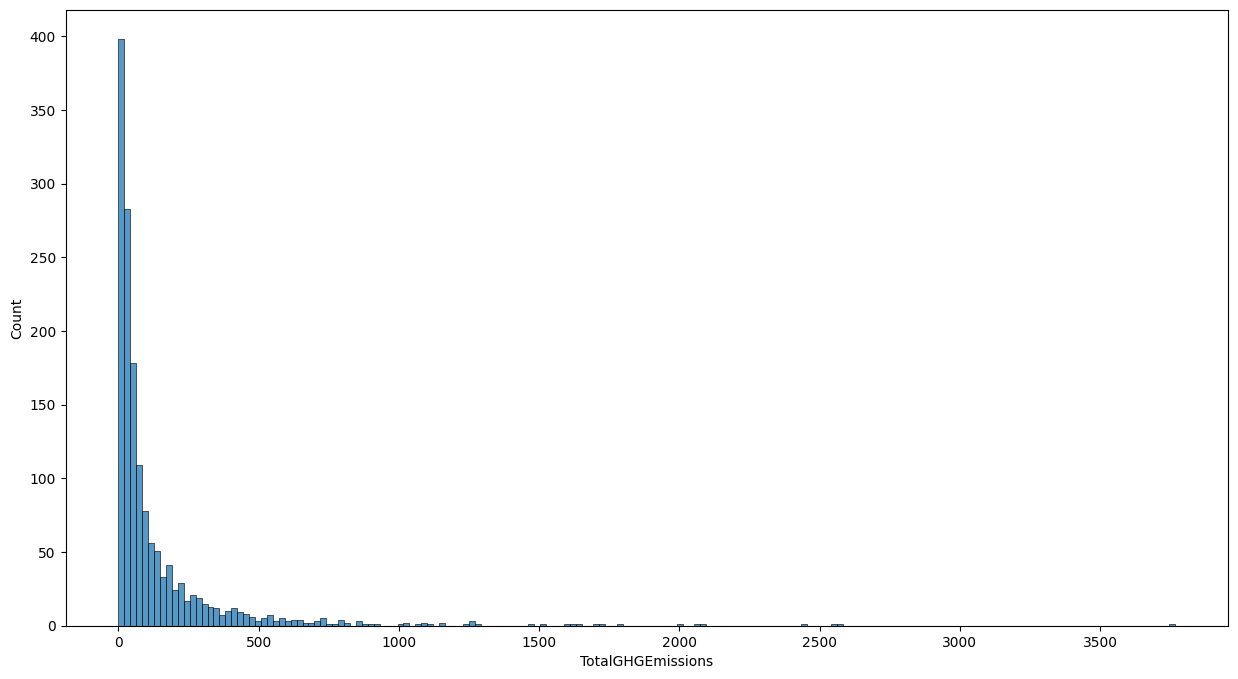

In [45]:
sns.histplot(building_data['TotalGHGEmissions'])

Les valeurs sont ici moins étalées, mais il reste quelques outliers. On va seulement retirer celui à plus de 3500 qui est vraiment très éloigné des autres, mais on conserve le reste.

In [46]:
index_drop = building_data.loc[building_data['TotalGHGEmissions']>3000].index
building_data.drop(index_drop,inplace=True)
building_data.reset_index(inplace=True,drop=True)

## Encodage des variables

Pour procéder à l'implémentation d'un algorithme de machine learning, on va tout d'abord devoir encoder nos variables qualitatives. On va utiliser un OneHotEncoder pour cela, afin d'avoir des labels utilisables mais non ordonnés. Nos variables qualitatives sont donc BuildingType, PrimaryPropertyType et YearBuilt. 

Cependant on a énormément d'années pour la variable YearBuilt, il serait donc pertinent de les regrouper avant d'encoder afin d'avoir un moins grand nombre de catégories. Nos années vont de 1900 à 2015, on va les regrouper par groupes de 20.

In [47]:
#Séparons nos années en différents groupes
period_length=20
start_year=1900
end_year=2015

year_range = end_year - start_year
modulo = year_range % period_length

#On calcule la dernière période à part
final_start = end_year - modulo
final_end = end_year + 1

In [48]:
#On crée une liste avec les années de départ
starts = np.arange(start_year, final_start, period_length).tolist()

#On ajoute l'année de fin de période
tuples = [(start, start+period_length) for start in starts]

#On rajoute la dernière période qu'on a calculée précédemment
tuples.append(tuple([final_start, final_end]))

#On crée les bins, en fermant à gauche pour ne pas inclure la dernière valeur de chaque période
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')

In [49]:
print(starts)
print('--------')
print(tuples)
print('--------')
print(bins)
print('--------')

[1900, 1920, 1940, 1960, 1980]
--------
[(1900, 1920), (1920, 1940), (1940, 1960), (1960, 1980), (1980, 2000), (2000, 2016)]
--------
IntervalIndex([[1900, 1920), [1920, 1940), [1940, 1960), [1960, 1980), [1980, 2000), [2000, 2016)], dtype='interval[int64, left]')
--------


In [50]:
#On remplace les noms de période pour retirer la dernière année
original_labels = list(bins.astype(str))
new_labels = ['{} - {}'.format(b.strip('[)').split(', ')[0], int(b.strip('[)').split(', ')[1])-1) for b in original_labels]
label_dict = dict(zip(original_labels, new_labels))

In [51]:
# On remet maintenant les périodes calculées dans le dataset
building_data['YearBuilt'] = pd.cut(building_data['YearBuilt'], bins=bins, include_lowest=True, precision=0)
building_data['YearBuilt'] = building_data['YearBuilt'].astype("str")
building_data = building_data.replace(label_dict)
np.sort(building_data['YearBuilt'].unique())

array(['1900 - 1919', '1920 - 1939', '1940 - 1959', '1960 - 1979',
       '1980 - 1999', '2000 - 2015'], dtype=object)

On a ainsi réduit notre variable YearBuilt en 6 catégories, ce qui facilitera grandement notre encodage. On va maintenant passer toutes nos variables catégoriques dans un OneHotEncoder pour pouvoir les utiliser dans nos algorithmes de machine learning.

In [52]:
BuildingType = building_data['BuildingType'].unique()
PrimaryPropertyType = building_data['PrimaryPropertyType'].unique()
YearBuilt = np.sort(building_data['YearBuilt'].unique())
Neighborhood = building_data['Neighborhood'].unique()
ohe = OneHotEncoder(categories=[BuildingType,PrimaryPropertyType,YearBuilt,Neighborhood],sparse_output=False)
encoded_data = ohe.fit_transform(building_data[['BuildingType','PrimaryPropertyType','YearBuilt','Neighborhood']])

In [53]:
# On remet nos données sous forme de dataframe

encoded_data = pd.DataFrame(encoded_data)
encoded_data.columns = ohe.get_feature_names_out()
encoded_data

,BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_SPS-District K-12,BuildingType_Campus,BuildingType_Nonresidential WA,PrimaryPropertyType_Hotel,PrimaryPropertyType_Other,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_University,PrimaryPropertyType_Small- and Mid-Sized Office,...,Neighborhood_LAKE UNION,Neighborhood_GREATER DUWAMISH,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_BALLARD,Neighborhood_NORTHWEST,Neighborhood_CENTRAL,Neighborhood_SOUTHWEST,Neighborhood_SOUTHEAST,Neighborhood_DELRIDGE,Neighborhood_NORTH
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1513,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1514,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot: >

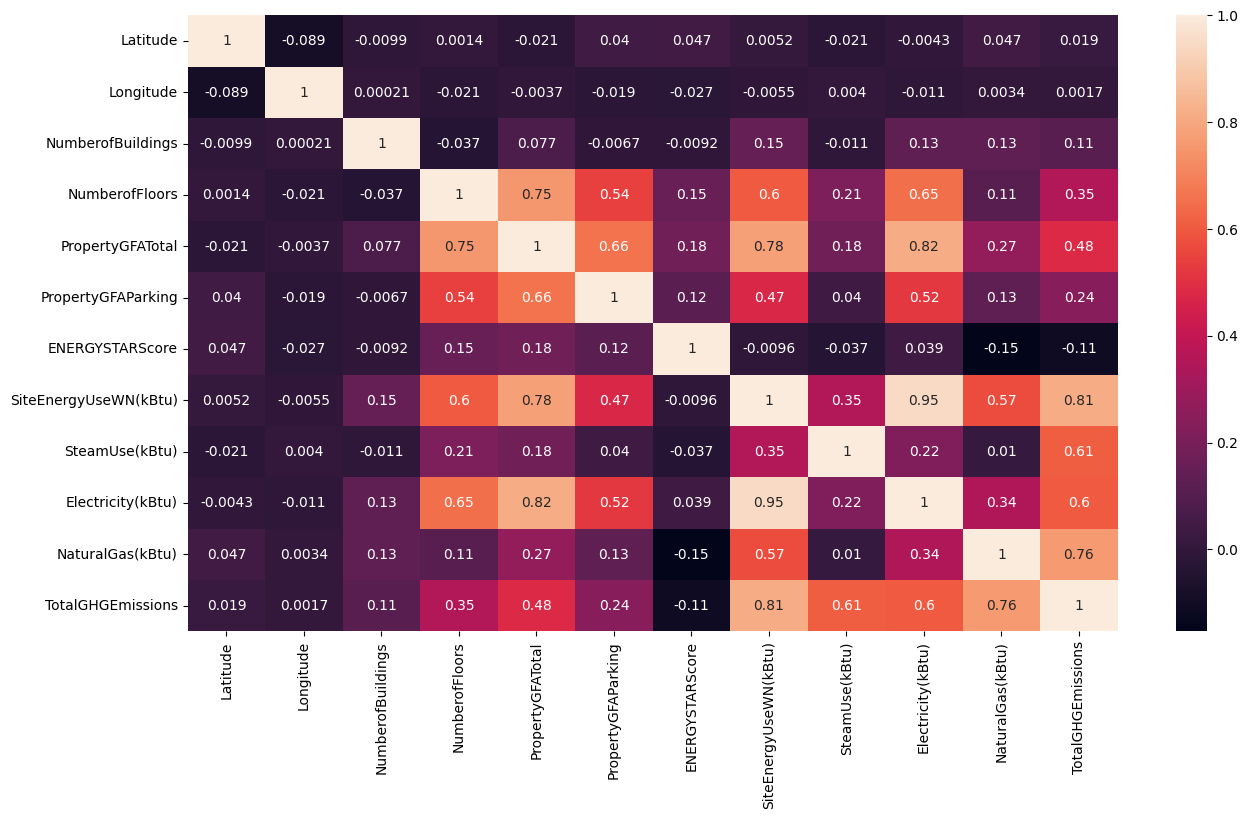

In [54]:
#Affichons maintenant les corrélations entre les différentes variables

corr_matrix = building_data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)

On a posé un OneHotEncoder sur nos variables qualitatives. La seule chose qu'il nous manque pour pouvoir commencer à prédire est maintenant d'encoder les variables 'SteamUse', 'Electricity', 'NaturalGas'. En effet, on a ici des valeurs, qui évidemment nous aident pour calculer l'énergie utilisée et l'émission de CO2, cependant ce ne sont pas des choses qu'on connaîtra quand on voudra prédire la consommation. Il serait donc utile de les encoder, pour cela, on va les remplacer par leur proportion sur le total.
    On voit d'autant plus une très forte relation entre Electricity et SiteEnergyUseWN, qui pourrait poser un problème de leak sur nos prédictions.

In [55]:
total_energy = building_data['SteamUse(kBtu)'] + building_data['Electricity(kBtu)'] + building_data['NaturalGas(kBtu)']
prop_steam = building_data['SteamUse(kBtu)'] / total_energy
prop_elec = building_data['Electricity(kBtu)'] / total_energy
prop_gas = building_data['NaturalGas(kBtu)'] / total_energy
building_data[['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)']] = pd.DataFrame([prop_steam,prop_elec,prop_gas]).T

In [56]:
building_data

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1920 - 1939,1.0,12,88434,0,60.0,7.456910e+06,0.277302,0.546060,0.176638,249.98
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1980 - 1999,1.0,11,103566,15064,61.0,8.664479e+06,0.000000,0.386609,0.613391,295.86
2,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,1960 - 1979,1.0,41,956110,196718,43.0,7.393711e+07,0.297113,0.682307,0.020579,2089.28
3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1920 - 1939,1.0,10,61320,0,56.0,6.946800e+06,0.325913,0.407519,0.266567,286.43
4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,1980 - 1999,1.0,18,175580,62000,75.0,1.465650e+07,0.000000,0.378802,0.621198,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,Nonresidential COS,Other,DELRIDGE,47.54067,-122.37441,1980 - 1999,1.0,1,18261,0,NaN,1.025432e+06,0.000000,0.678440,0.321560,20.33
1513,Nonresidential COS,Other,DOWNTOWN,47.59625,-122.32283,2000 - 2015,1.0,1,16000,0,NaN,1.053706e+06,0.000000,0.417296,0.582704,32.17
1514,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1960 - 1979,1.0,1,13157,0,NaN,6.053764e+06,0.000000,0.310820,0.689180,223.54
1515,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,47.52832,-122.32431,1980 - 1999,1.0,1,14101,0,NaN,7.828413e+05,0.000000,0.484898,0.515102,22.11


<AxesSubplot: >

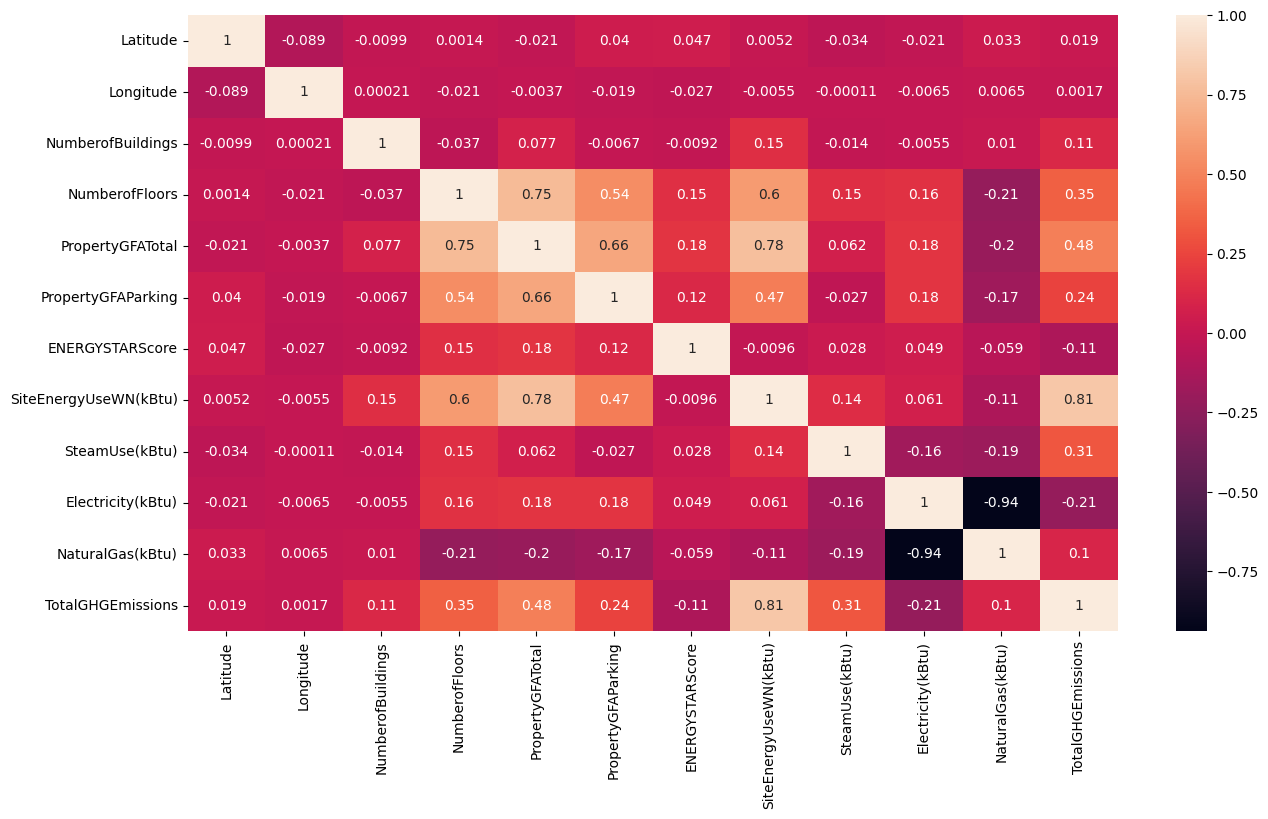

In [57]:
corr_matrix = building_data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)

Avant de passer à la suite, il va évidemment falloir standardiser nos valeurs car on n'a pas les mêmes échelles sur les différentes variables et on ne veut pas que certaines variables prévalent sur les autres. On fait cependant attention à ne pas scale nos variables cibles.

In [58]:
#On encode les valeurs numériques avec un standard scaler
std_scaler = StandardScaler()
building_data[['NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking']] = pd.DataFrame(std_scaler.fit_transform(building_data[['NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking']]))

mmscaler = MinMaxScaler()
building_data[['Latitude','Longitude']] = pd.DataFrame(mmscaler.fit_transform(building_data[['Latitude','Longitude']]))

In [59]:
#On retire les colonnes des variables qu'on a encodées précédemment
building_data.drop(['BuildingType','PrimaryPropertyType','Neighborhood','YearBuilt'], axis=1, inplace=True)
building_data

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
0,0.457508,0.492134,-0.073822,1.239631,-0.117179,-0.316166,60.0,7.456910e+06,0.277302,0.546060,0.176638,249.98
1,0.461833,0.519197,-0.073822,1.081338,-0.033973,0.026583,61.0,8.664479e+06,0.000000,0.386609,0.613391,295.86
2,0.465222,0.491401,-0.073822,5.830126,4.653877,4.159728,43.0,7.393711e+07,0.297113,0.682307,0.020579,2089.28
3,0.466069,0.501133,-0.073822,0.923045,-0.266269,-0.316166,56.0,6.946800e+06,0.325913,0.407519,0.266567,286.43
4,0.464419,0.475603,-0.073822,2.189389,0.362008,1.094510,75.0,1.465650e+07,0.000000,0.378802,0.621198,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...
1512,0.138577,0.249367,-0.073822,-0.501591,-0.503036,-0.316166,NaN,1.025432e+06,0.000000,0.678440,0.321560,20.33
1513,0.386392,0.593188,-0.073822,-0.501591,-0.515469,-0.316166,NaN,1.053706e+06,0.000000,0.417296,0.582704,32.17
1514,0.565588,0.359819,-0.073822,-0.501591,-0.531101,-0.316166,NaN,6.053764e+06,0.000000,0.310820,0.689180,223.54
1515,0.083512,0.583322,-0.073822,-0.501591,-0.525911,-0.316166,NaN,7.828413e+05,0.000000,0.484898,0.515102,22.11


In [60]:
#On rajoute les colonnes codées par le OneHotEncoder, et on exporte le dataset pour la suite.
ml_data = pd.concat([encoded_data,building_data], axis=1)
ml_data.to_csv('ml_data_prop.csv', index=False)